In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-dataset/train_cancer/benign/20.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/6.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/30.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/38.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/42.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/33.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/35.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/41.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/29.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/23.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/7.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/28.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/22.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/40.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/24.jpg
/kaggle/input/skin-cancer-dataset/train_cancer/benign/13.jpg
/kaggle/input/skin-cancer-

# **Import**

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.callbacks import ReduceLROnPlateau

# **1. Data Import**

In [35]:
def get_images(directory):
    images = []
    
    for filename in os.listdir(directory):
        try:
            img = Image.open(os.path.join(directory, filename))
            img = img.resize((128, 128))
            img = img.convert('RGB')
            img = np.array(img) / 255.0
            images.append(img)
        except OSError as e:
            print(f"Error loading {os.path.join(directory, filename)}: {e}")
            continue
    return images

In [36]:
benign = get_images('/kaggle/input/skin-cancer-dataset/train_cancer/benign')
malignant = get_images('/kaggle/input/skin-cancer-dataset/train_cancer/malignant')

**Data Description**
* **Malignant: This folder contains images of skin lesions that have been diagnosed as malignant, indicating the presence of skin cancer. These images can be used for training models to detect and differentiate malignant skin conditions.**

* **Benign: This folder includes images of benign skin lesions, which are non-cancerous and pose no immediate threat. These images are essential for training models to accurately distinguish between harmful and harmless skin conditions.**

In [37]:
len(malignant)

240

# **2. Data Visualization**

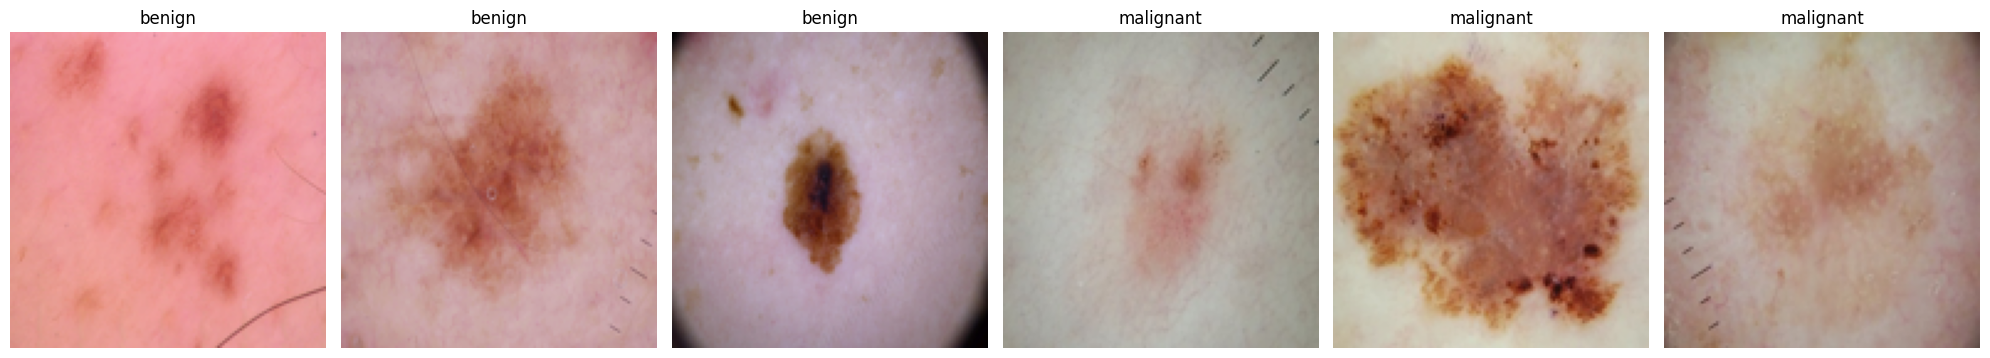

In [38]:
fig, ax = plt.subplots(1, 6, figsize=(20, 10))

ax[0].imshow(benign[0])
ax[1].imshow(benign[1])
ax[2].imshow(benign[2])
ax[3].imshow(malignant[0])
ax[4].imshow(malignant[1])
ax[5].imshow(malignant[2])
ax[0].set_title('benign')
ax[1].set_title('benign')
ax[2].set_title('benign')
ax[3].set_title('malignant')
ax[4].set_title('malignant')
ax[5].set_title('malignant')

for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

# **3. Data Transfrom**

In [39]:
train_images = np.concatenate((benign, malignant))
train_labels = np.concatenate((np.ones(len(benign)), np.zeros(len(malignant))))

In [40]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
batch_size = 32

train = train_ds.shuffle(buffer_size=len(train_images)).batch(batch_size)

# **4. Modeling**

## **CNN Model**

In [41]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(128, 128, 3), padding='valid'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
history = model.fit(train, validation_data = train, epochs = 10, verbose = 2)

Epoch 1/10
9/9 - 8s - 879ms/step - accuracy: 0.8556 - loss: 0.4332 - val_accuracy: 0.8889 - val_loss: 0.3265
Epoch 2/10
9/9 - 10s - 1s/step - accuracy: 0.8889 - loss: 0.3115 - val_accuracy: 0.8889 - val_loss: 0.2349
Epoch 3/10
9/9 - 5s - 599ms/step - accuracy: 0.8926 - loss: 0.2620 - val_accuracy: 0.9481 - val_loss: 0.2869
Epoch 4/10
9/9 - 10s - 1s/step - accuracy: 0.9185 - loss: 0.2573 - val_accuracy: 0.9519 - val_loss: 0.1949
Epoch 5/10
9/9 - 5s - 601ms/step - accuracy: 0.9259 - loss: 0.1916 - val_accuracy: 0.9148 - val_loss: 0.1794
Epoch 6/10
9/9 - 6s - 657ms/step - accuracy: 0.9444 - loss: 0.1582 - val_accuracy: 0.9259 - val_loss: 0.1544
Epoch 7/10
9/9 - 10s - 1s/step - accuracy: 0.8704 - loss: 0.3758 - val_accuracy: 0.8963 - val_loss: 0.2280
Epoch 8/10
9/9 - 5s - 590ms/step - accuracy: 0.9000 - loss: 0.2045 - val_accuracy: 0.9037 - val_loss: 0.1734
Epoch 9/10
9/9 - 5s - 604ms/step - accuracy: 0.8963 - loss: 0.2008 - val_accuracy: 0.8963 - val_loss: 0.1696
Epoch 10/10
9/9 - 11s - 1

## **Plot**

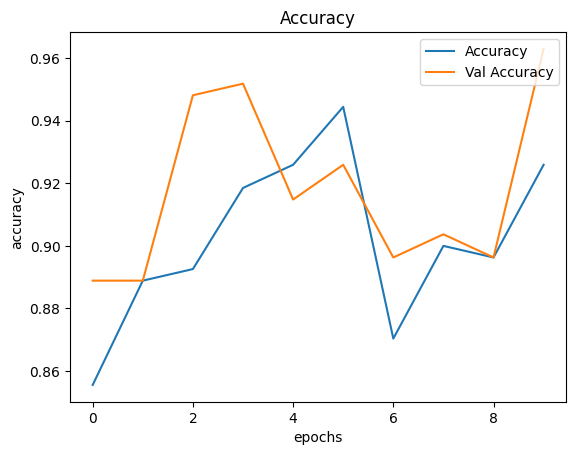

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Accuracy', 'Val Accuracy'], loc = 'upper right')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

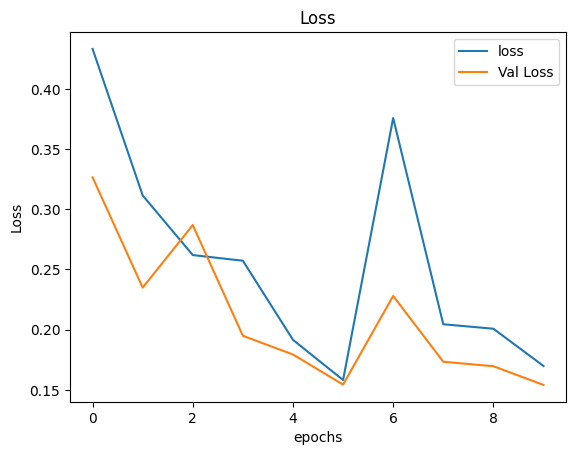

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'Val Loss'], loc = 'upper right')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

In [46]:
model.evaluate(train,verbose=2)

9/9 - 1s - 138ms/step - accuracy: 0.9630 - loss: 0.1541


[0.15412794053554535, 0.9629629850387573]

## **Prediction**

In [47]:
pred = model.predict(train)
pred_cnn = (pred > 0.5).astype("int32")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


In [48]:
cm = confusion_matrix(train_labels, pred_cnn)

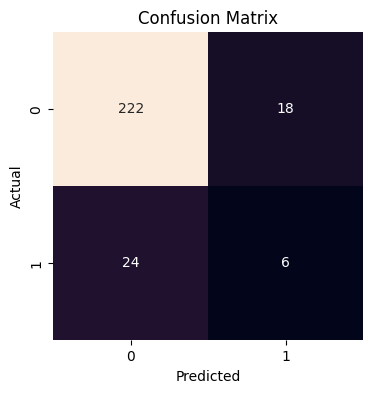

In [49]:
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## **Classification Report**

In [50]:
accuracy = accuracy_score(train_labels, pred_cnn)
model_report = classification_report(train_labels, pred_cnn)
print(f'Model accuracy: {round(accuracy,4)}')
print('Classification Report:')
print(f'{model_report}')

Model accuracy: 0.8444
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       240
         1.0       0.25      0.20      0.22        30

    accuracy                           0.84       270
   macro avg       0.58      0.56      0.57       270
weighted avg       0.83      0.84      0.84       270



**Thankyou. Please leave your advice in the comments**